# Plague Classification of IP102 Dataset Using MobileNetV2

## Import Libraries 📦

In [1]:
# Import required libraries
import os
import glob

import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix

# Define root directory (where data and annotations are located)
root_dir = "../Dataset"

## Check if GPU is Available 👨‍💻

In [4]:
# Check if TensorFlow is using GPU
print("Is TensorFlow using GPU? ", tf.config.list_physical_devices('GPU'))

Is TensorFlow using GPU?  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Prepare Data 🏷️

In [5]:
# Create dictionary that maps integer class index to string with name of class
file = os.path.join(root_dir, "classes.txt")   # txt file containing the name of the corresponding class

with open(file, "r") as file:
    lines = file.readlines()

classes = {}

# Get key and value for each class (line of txt file)
for line in lines:
    key, value = line.strip().split(" ", 1)
    classes[int(key.strip()) - 1] = value.strip()

In [6]:
# Create train, val and test directories (if have not been already created) by moving images from images folder to train, val and test folders
# directories to create (train, val and test)

if not os.path.isdir(os.path.join(root_dir, "train")):
    dirs = ["train", "val", "test"]

    for name in dirs:
        # inside this directory (train, val or test) create a directory for each insect class
        for class_name in classes.values():
            os.makedirs(os.path.join(root_dir, name, class_name))

    # txt files containig paths and classes of train, validation and test data
    filenames = ["train.txt", "val.txt", "test.txt"]
    
    # Move data from images directory to its corresponding directory
    for name, fname in zip(dirs, filenames):
        with open(os.path.join(root_dir, fname)) as infile:  # Read file with image paths and classes
            for line in infile:
                # Get image name and class
                img_name, img_class = line.strip().split(" ")
                os.rename(os.path.join(root_dir, "images", img_name), os.path.join(root_dir, name, classes[int(img_class)], img_name))
    

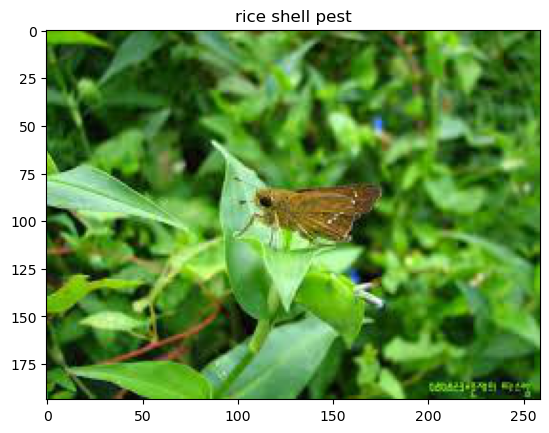

In [7]:
# Show a random image from IP102 dataset along its corresponging class

# paths of train images
train_paths = glob.glob(os.path.join(root_dir, "train/*/*"))
idx = np.random.randint(len(train_paths))
image = tf.keras.utils.load_img(train_paths[idx])
plt.imshow(image)
plt.title(train_paths[idx].split("/")[3])
plt.show()

## Load and Preprocess Data 🛠️

In [197]:
# Create Image Data Generators for loading data with data augmentation for training and 
# normalize pixel intensiry values to range [0, 1]
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
    #horizontal_flip=True,
    #vertical_flip=True)  # Rotations?

# For test and val only normalize pixel intensiry values to range [0, 1]
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size=64
# Resize images to 224x224
train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "train"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "val"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False)

Found 45095 images belonging to 102 classes.
Found 7508 images belonging to 102 classes.
Found 22619 images belonging to 102 classes.


## Create Model 👷‍♂️

In [20]:
# Download pretrained ResNet50 with ImageNet
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet")

In [ ]:
# Look at what this network does to an example batch of images
image_batch, label_batch = next(iter(train_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
# Freeze base model weigts
base_model.trainable = False

In [ ]:
base_model.summary()

In [ ]:
# Add new classification head

# Add Global Average Pooling to get a single 2048-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Add Dense layer for prediction
prediction_layer = tf.keras.layers.Dense(len(classes), activation="softmax")

In [ ]:
# Build the model by chaining together base model and new classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # training is set to False so batch normalization works in inference mode
x = base_model(inputs)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

## Train Freezed Model (Only Train Modified Top) 🥶

In [ ]:
# Compile the model

# Reduce learning rate by a factor of 0.1 every 25 epochs
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    name='ExponentialDecay'
)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

# Define callbacks

# For saving training history
csv_log = tf.keras.callbacks.CSVLogger("./Logs/history_MobileNetv2_")

# Save best model every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Models/mobilenetv2.keras_",
    monitor="val_accuracy", 
    save_best_only=True,
    mode="max")

# Stop if val accuracy does not increase after 10 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='max',
    start_from_epoch=10)

In [ ]:
# Train freezed model for 50 epochs
initial_epochs = 50
history = model.fit(train_gen, epochs=initial_epochs, validation_data=val_gen, callbacks=[csv_log, checkpoint, early_stop])

In [ ]:
# Plot history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.7])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tune Model Unfreezing 4 Layers of Base Model 💪

In [ ]:
# Look at how many layers the base model has 
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
model.summary()

In [ ]:
# Unfreeze model for fine tuning
base_model.trainable = True

# Fine tune 4 layers of base model
fine_tune = 4

# Freeze all base model layers but last 4 layers
for layer in base_model.layers[:-fine_tune]:
  layer.trainable = False

In [ ]:
# Reduce learning rate by a factor of 0.1 every 25 epochs
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1e-6,
    decay_steps=100000,
    decay_rate=0.96,
    name='ExponentialDecay'
)

# Recompile model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

# Define callbacks

# For saving training history
csv_log = tf.keras.callbacks.CSVLogger("./Logs/history_mobilenetv2_fine_")

# Save best model every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Models/mobilenetv2_fine.keras_",
    monitor="val_accuracy", 
    save_best_only=True,
    mode="max")

In [ ]:
model.summary()

In [ ]:
# Fine tune model

fine_tune_epochs = 100
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_gen, 
                         epochs=total_epochs, 
                         validation_data=val_gen,
                         initial_epoch=len(history.epoch),
                         callbacks=[csv_log, checkpoint])

In [ ]:
# Plot history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.65])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([1.4,2.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Retrain with Higher Learning Rate 🏋️

In [ ]:
# Train the model for 25 epochs with higer lr
# Reduce learning rate by a factor of 0.1 every 25 epochs
lr = 1e-5

# Recompile model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

# Define callbacks

# For saving training history
csv_log = tf.keras.callbacks.CSVLogger("./Logs/history_mobilenetv2_fine2_")

# Save best model every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Models/mobilenetv2_fine2.keras_",
    monitor="val_accuracy", 
    save_best_only=True,
    mode="max")

In [ ]:
fine_tune2_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs + fine_tune2_epochs

history_fine = model.fit(train_gen, 
                         epochs=total_epochs, 
                         validation_data=val_gen,
                         initial_epoch=initial_epochs + fine_tune_epochs,
                         callbacks=[csv_log, checkpoint])

In [ ]:
# Plot history
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([.8,1.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Plot Full Training History 📈

In [27]:
# Concatenate history of each training to plot all history
hist1 = pd.read_csv("Logs/history_MobileNetv2")
hist2 = pd.read_csv("Logs/history_mobilenetv2_fine")
hist3 = pd.read_csv("Logs/history_mobilenetv2_fine2")

history_all = pd.concat([hist1, hist2, hist3])
history_all["epoch"] += 1
epoch0 = pd.DataFrame({'epoch':0, 'accuracy':0, 'loss':10,
                        'val_accuracy':0, 'val_loss':10},
                                                            index =[0])
history_all = pd.concat([epoch0, history_all])  # Add epoch 0 to dataframe

# Extract acc, val_acc, loss and val_loss
acc = history_all['accuracy']
val_acc = history_all['val_accuracy']

loss = history_all['loss']
val_loss = history_all['val_loss']

epochs = history_all["epoch"]

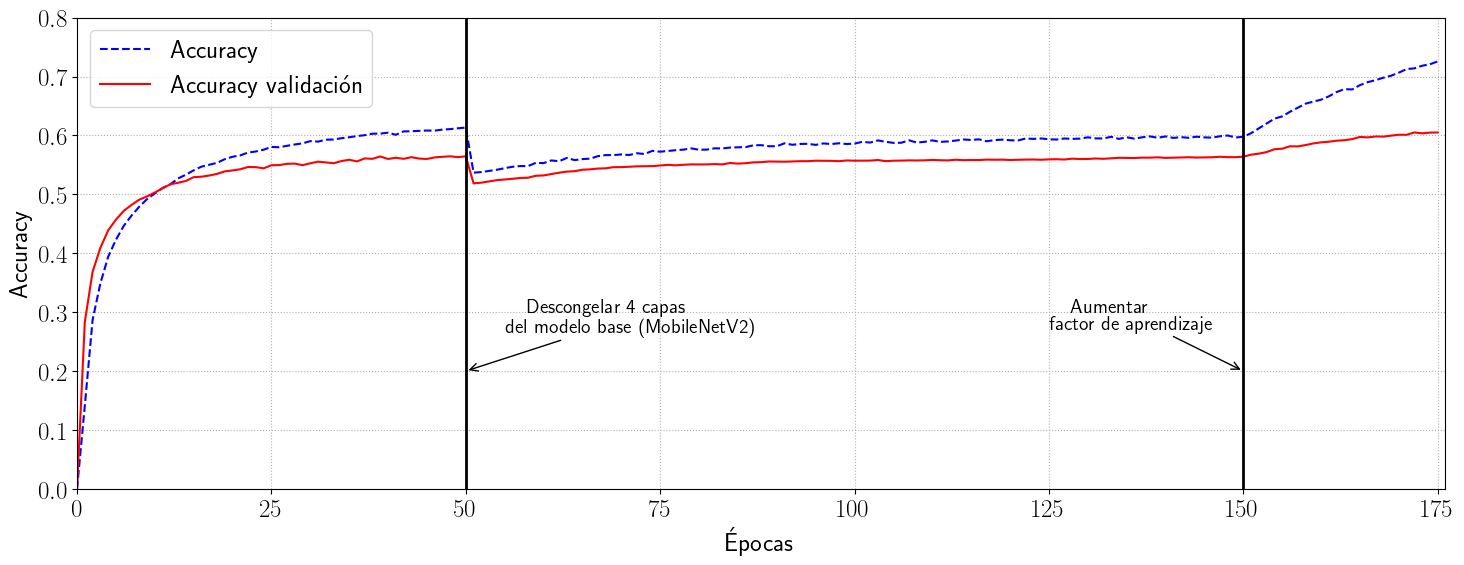

In [38]:
# Plot accuracy
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True # TeX rendering

#with plt.style.context("dark_background"):
    
plt.figure(figsize=(15, 6))
plt.plot(epochs, acc, "b--", label="Accuracy")
plt.plot(epochs, val_acc, "r-", label="Accuracy validación")
plt.plot([50, 50], [-1, 0.8], "k", linewidth=2)
plt.plot([150, 150], [-1, 0.8], "k", linewidth=2)
plt.xlabel(r"Épocas")
plt.ylabel(r"Accuracy")
plt.ylim([0, 0.8])
plt.xlim([0, 176])
plt.annotate(r"Descongelar 4 capas\\ del modelo base (MobileNetV2)", (50, 0.2), xytext=(55, 0.3), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.annotate(r"Aumentar\\ factor de aprendizaje", (150, 0.2), xytext=(125, 0.3), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175])
plt.grid(linestyle="dotted")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/acc_plot.svg", dpi=400)

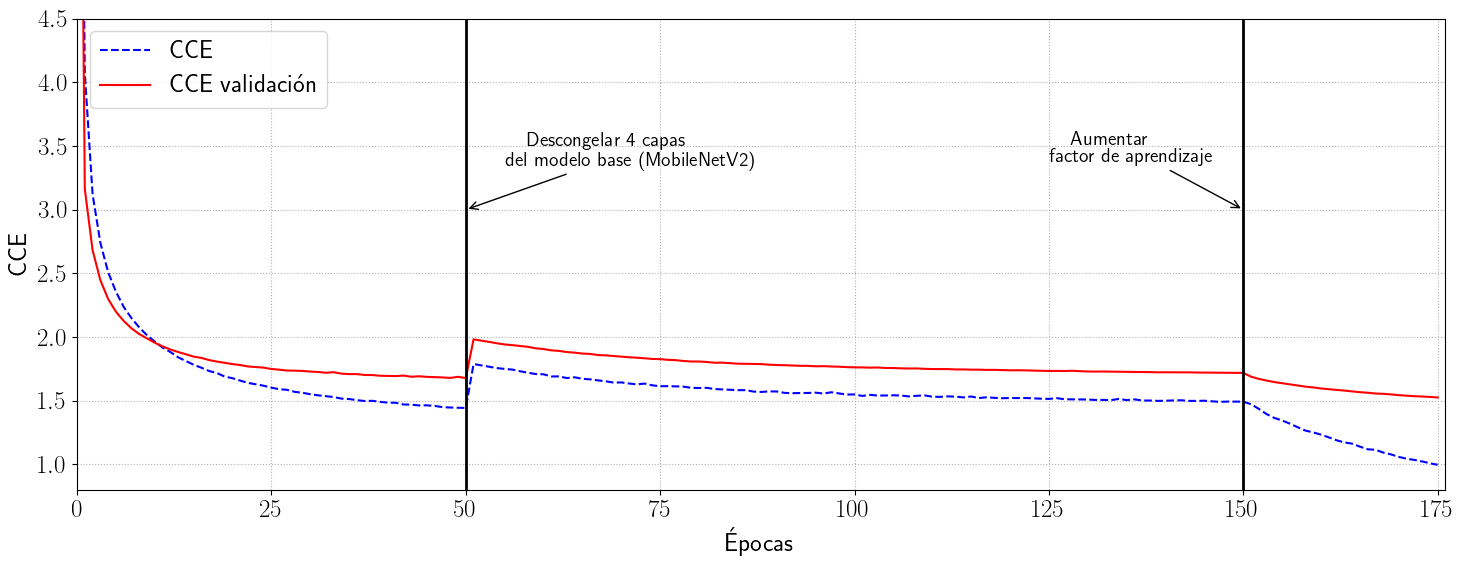

In [37]:
# Plot loss
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True # TeX rendering
    
plt.figure(figsize=(15, 6))
plt.plot(epochs, loss, "b--", label="CCE")
plt.plot(epochs, val_loss, "r-", label="CCE validación")
plt.plot([50, 50], [0, 4.6], "k", linewidth=2)
plt.plot([150, 150], [0, 4.6], "k", linewidth=2)
plt.xlabel(r"Épocas")
plt.ylabel(r"CCE")
plt.ylim([0.8, 4.5])
plt.xlim([0, 176])
plt.annotate(r"Descongelar 4 capas\\ del modelo base (MobileNetV2)", (50, 3), xytext=(55, 3.5), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.annotate(r"Aumentar\\ factor de aprendizaje", (150, 3), xytext=(125, 3.5), arrowprops=dict(arrowstyle="->"), fontsize=14)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175])
plt.grid(linestyle="dotted")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/loss_plot.svg", dpi=400)

## Evaluate Model 🧐

In [198]:
model = tf.keras.models.load_model("./Models/mobilenetv2_fine2.keras", compile=False)

In [199]:
# Make predictions over test set
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)  # Apply argmax to get class of each image

2024-05-16 09:57:29.473038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-16 09:57:29.567800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22619/22619 [==============================] - 130s 6ms/step


In [200]:
# Create classification report
print(classification_report(test_gen.classes, y_pred, target_names=test_gen.class_indices.keys()))

                                 precision    recall  f1-score   support

                  Adristyrannus       0.66      0.56      0.61        94
       Aleurocanthus spiniferus       0.83      0.85      0.84       208
                    Ampelophaga       0.72      0.68      0.70       230
    Aphis citricola Vander Goot       0.54      0.55      0.54       106
               Apolygus lucorum       0.38      0.17      0.24       115
           Bactrocera tsuneonis       0.63      0.24      0.34        51
                Beet spot flies       0.59      0.48      0.53        90
   Brevipoalpus lewisi McGregor       0.71      0.62      0.67        24
             Ceroplastes rubens       0.79      0.73      0.76        78
           Chlumetia transversa       0.58      0.39      0.47        92
          Chrysomphalus aonidum       0.63      0.59      0.61        68
              Cicadella viridis       0.75      0.62      0.68       384
                   Cicadellidae       0.74      0.

In [201]:
# Generate confussion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

In [202]:
# Calculate sensitivity for each class from confussion matrix
TP = np.diag(cm) # True positive
FN = np.sum(cm, axis=1) - TP # False negative
S = TP / (TP + FN)  # Sensitivity

In [203]:
# Calculate Geometric Mean using sensitivity
GM = np.prod(S ** (1/102))
print(f"Geometric mean for model is: {GM}")

Geometric mean for model is: 0.463421523547116


## Visualize Grad-CAM 📸

In [244]:
# Get 8 images and labels from test set to visualize grad cam
test_gen = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True)
test = iter(test_gen)

imgs = []
labels = [] 
for i in range(8):
    img, label = next(test)
    imgs.append(img[0])
    labels.append(np.argmax(label))

Found 22619 images belonging to 102 classes.


In [245]:
# Unwrap model to use with gradcam
def unwrap_model(model):
    inception = model.get_layer('mobilenet_1.00_224')
    inp = inception.input
    out = model.get_layer('global_average_pooling2d_6')(inception.output)
    out = model.get_layer('dropout_6')(out)
    out = model.get_layer('dense_6')(out)
    return tf.keras.Model(inp, out) 

model_unwraped = unwrap_model(model)
model_unwraped.summary()

Model: "model_233"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                  

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [246]:
last_conv_layer = "conv_pw_13"

In [247]:
# Function to generate gradcam heatmap
# from: https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=None):
    # Input is (224, 244, 3)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    
    # Create model that maps input image to activations of last conv layer and output preds
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [248]:
# Create sumperimposed image
# From: https://keras.io/examples/vision/grad_cam/
def display_gradcam(img, heatmap, alpha=0.9):

    # Rescale heatmap and img to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

In [249]:
# Get gradcams for 8 images
gradcams = []
for img in imgs:
    heatmap = make_gradcam_heatmap(img, model_unwraped, last_conv_layer)
    gradcams.append(display_gradcam(img, heatmap, alpha=0.7))

In [250]:
# Get model prediction for each image
imgs = np.array(imgs)  # Convert to batch (8, 224, 224, 3)
preds = model.predict(imgs)
preds = np.argmax(preds, axis=1)  # Get class index

1/1 [==============================] - 0s 18ms/step


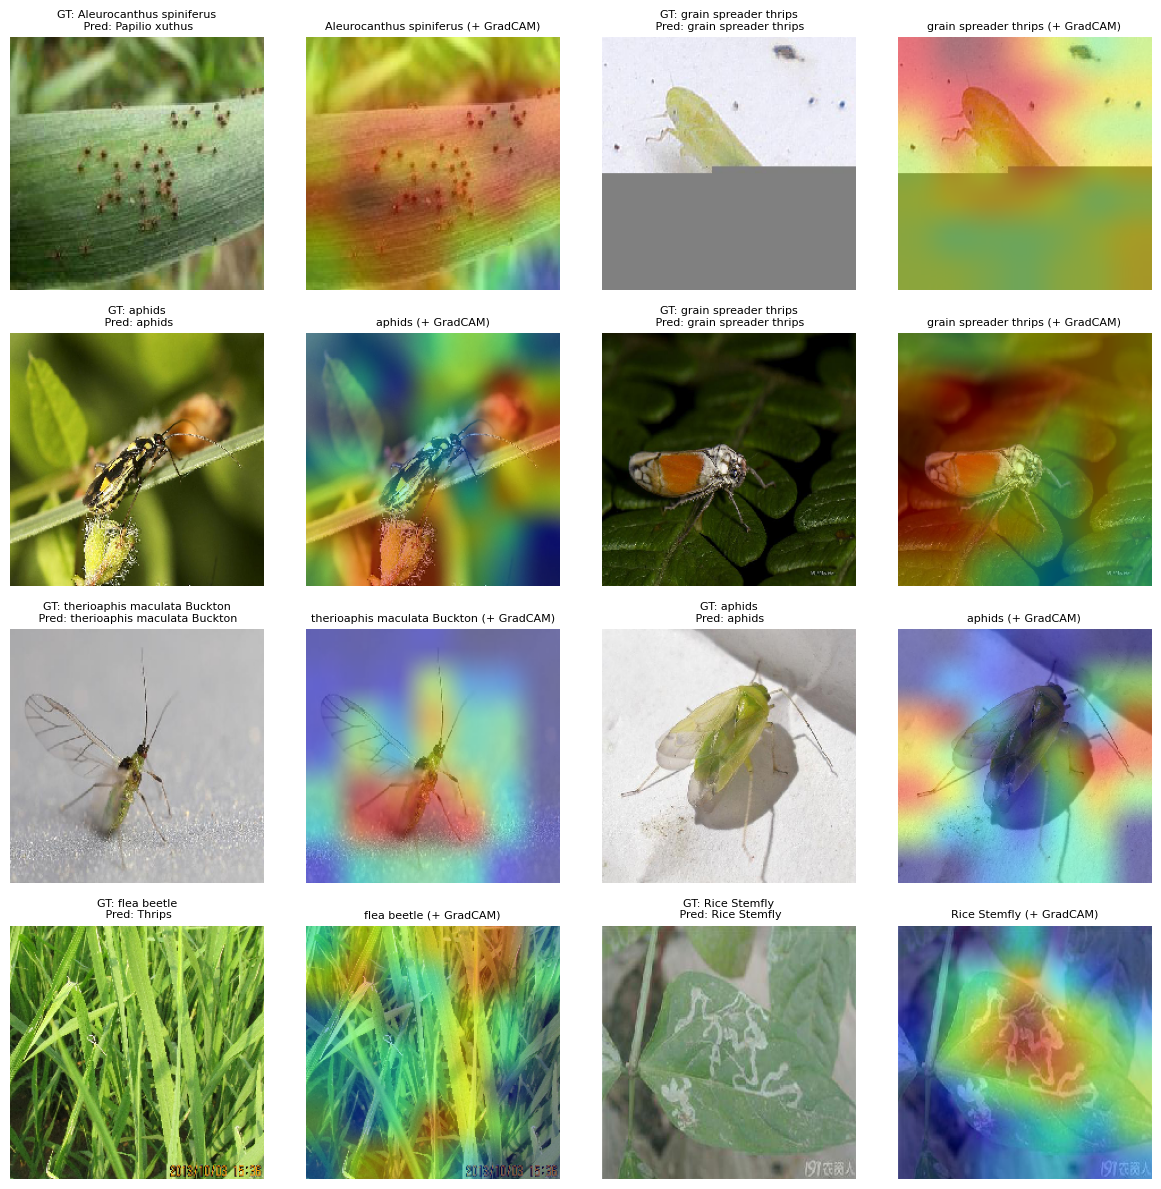

In [252]:
# Generate image with gradcams
# Based on: https://github.com/thushv89/manning_tf2_in_action/blob/master/Ch07-Improving-CNNs-and-Explaining/7.3.Interpreting_CNNs_GradCAM.ipynb

fig, axes = plt.subplots(4, 4, figsize=(12,  12))

for i, cam in enumerate(gradcams):
    img = imgs[i]
    offset = 2 * (i%2)
    
    # Plot eeach image
    axes[i//2][offset].imshow(img)
    
    # Plot gradcam
    axes[i//2][offset+1].imshow(cam)
    
    # Set label and turn off axis
    axes[i//2][offset].set_title(f"GT: {classes[labels[i]]}\n Pred: {classes[preds[i]]}", fontsize=8)
    axes[i//2][offset+1].set_title(classes[labels[i]] + " (+ GradCAM)", fontsize=8)
    axes[i//2][offset].axis("off")
    axes[i//2][offset+1].axis("off")
    
plt.savefig("Figures/gradcam.png", dpi=400)
plt.tight_layout()

## Inference Time 🤠

In [320]:
test_data = iter(test_gen)

1/1 [==============================] - 0s 20ms/step


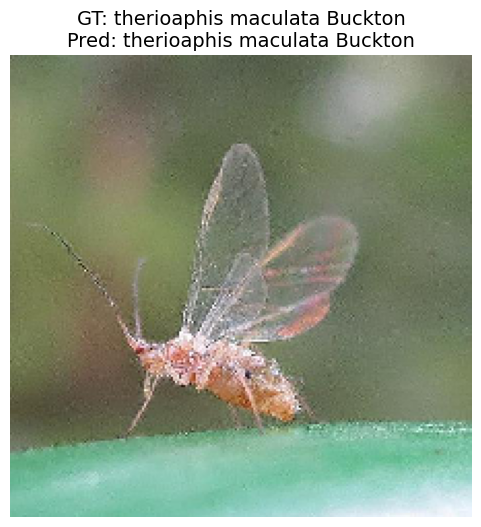

In [321]:
# Look at inferences over test set
img, label = next(test_data)  # Get image and label from image generator
label = np.argmax(label)  # Get class index

# Get pred from model
pred = model.predict(img)
pred = np.argmax(pred)  # Get class idx

plt.figure(figsize=(6, 6))
plt.imshow(img[0])
plt.title(f"GT: {classes[label]}\nPred: {classes[pred]}", fontsize=14)
plt.axis("off")
plt.show()